In [1]:
# Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install rawpy
# !{sys.executable} -m pip install Pillow


import os
import glob
import rawpy

import cv2 
import numpy as np

from skimage import io
from sklearn.cluster import KMeans
from PIL import Image



We are importing RAW image files that the camera makes. These have a lot of image data, as they are about 30mb per file. It is unfortunate that we are simply discarding it, maybe this can be useful later. PIL is also known as Pillow on pip apparently. This process may take a hot minute, it took about, 4 minutes for 9 pictures, that all were converted to LARGER filesizes even though they were png. 

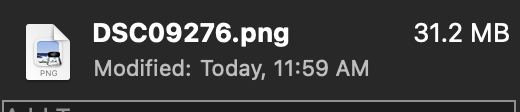

In [2]:

def convert_arw_to_png(arw_folder, png_folder):
    arw_files = glob.glob(os.path.join(arw_folder, "*.ARW"))
    os.makedirs(png_folder, exist_ok=True)

    for arw_file in arw_files:
        with rawpy.imread(arw_file) as raw:
            rgb = raw.postprocess()
        png_file = os.path.join(png_folder, os.path.splitext(os.path.basename(arw_file))[0] + '.png')
        Image.fromarray(rgb).save(png_file)


arw_folder = r'C:\Users\rober\Pictures\mar 21\purple !!!'
png_folder = r'C:\Users\rober\Pictures\mar 21\purple !!!\png/'

convert_arw_to_png(arw_folder, png_folder)


We're pre-processing a little bit here, image is made to be 500,500, and a small gaussian blur is applied.  
Below where the comment is, is where we can sideload another png_folder, in case we do not want to convert the raw files again. 

In [3]:


png_folder = r'C:\Users\rober\Pictures\mar 21\purple !!!\png\\'
preprocessed_folder = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed\\'

def preprocess_images(png_folder, preprocessed_folder):
    png_files = glob.glob(os.path.join(png_folder, "*.png"))
    os.makedirs(preprocessed_folder, exist_ok=True)

    for png_file in png_files:
        img = cv2.imread(png_file)

        # Resize the image
        img_resized = cv2.resize(img, (500, 500))

        # Apply Gaussian blur
        img_blurred = cv2.GaussianBlur(img_resized, (5, 5), 0)

        # Save the preprocessed images
        preprocessed_file = os.path.join(preprocessed_folder, os.path.basename(png_file))
        cv2.imwrite(preprocessed_file, img_blurred)

preprocess_images(png_folder, preprocessed_folder)


More features for preprocessing, color conversion, extraction of a histogram, gaussian blur, 

We select the folders, partially because we are already a few steps in, and do not necesarily want to run everything all at once.  Glob is just our file processing.

    Grayscale: By converting the color image to grayscale, we reduce the complexity of the image and focus on the intensity values, which can help identify edges and other features.

    Histogram of Oriented Gradients (HOG): This feature descriptor computes the distribution of edge orientations in an image. HOG is useful for object detection and recognition tasks because it captures the shape and texture of an object.

    Gaussian Blur: Applying Gaussian blur to an image can reduce noise and enhance the edges. This feature can help the model better identify edges and shapes in the image.

    Canny Edges: This feature is generated by detecting edges in the image using the Canny edge detection algorithm. It can help the model to identify edges and contours in the image.

    Color Histogram: This feature captures the distribution of colors in the image. It can help the model to recognize objects based on their color and distinguish between different objects in the image.
    
    
    Everything then gets saved as an array in numpy. Standard stuff. 

In [45]:
from skimage import feature
from skimage import color

preprocessed_folder = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed\\'
save_folder = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2\\'

features_array = []

def extract_features(preprocessed_folder, save_folder):
    preprocessed_files = glob.glob(os.path.join(preprocessed_folder, "*.png"))

    for i, preprocessed_file in enumerate(preprocessed_files):
        img = cv2.imread(preprocessed_file)

        # Convert the image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Save the grayscale image
        gray_file = os.path.join(save_folder, os.path.basename(preprocessed_file))
        cv2.imwrite(gray_file, gray_img)

        # Extract the histogram of oriented gradients (HOG) feature
        hog_feature = feature.hog(gray_img)

        # Gaussian blur
        blur = cv2.GaussianBlur(gray_img, (5, 5), 0)
        # Save the blurred image
        blur_file = os.path.join(save_folder, os.path.splitext(os.path.basename(preprocessed_file))[0] + '_blur.png')
        cv2.imwrite(blur_file, blur)

        edges = cv2.Canny(gray_img, 100, 200)

        # Save the edges image
        edges_file = os.path.join(save_folder, os.path.splitext(os.path.basename(preprocessed_file))[0] + '_edges.png')
        cv2.imwrite(edges_file, edges)

        # Compute the color histogram
        color_hist = color.rgb2gray(img).flatten()

        # Convert the image to HSV color space to identify the location of different colors
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Save the HSV image
        hsv_file = os.path.join(save_folder, os.path.splitext(os.path.basename(preprocessed_file))[0] + '_hsv.png')
        cv2.imwrite(hsv_file, hsv)

        # Combine the features
        combined_features = np.concatenate((hog_feature, color_hist))
        num_features = len(hog_feature) + len(color_hist)
        
        if i == 0:
            global features_array
            features_array = np.empty((len(preprocessed_files), num_features))
            
        features_array[i] = combined_features
        
    return features_array


features_array = extract_features(preprocessed_folder, save_folder)

array_preprocess = np.save("array_preprocess.npy", features_array)


This cell is a way we can display our pictures using a matrix. We are showing off the processing we have just done to the plants. 

A Matplotlib plot of the images, to show what has actually been done to the folder. 

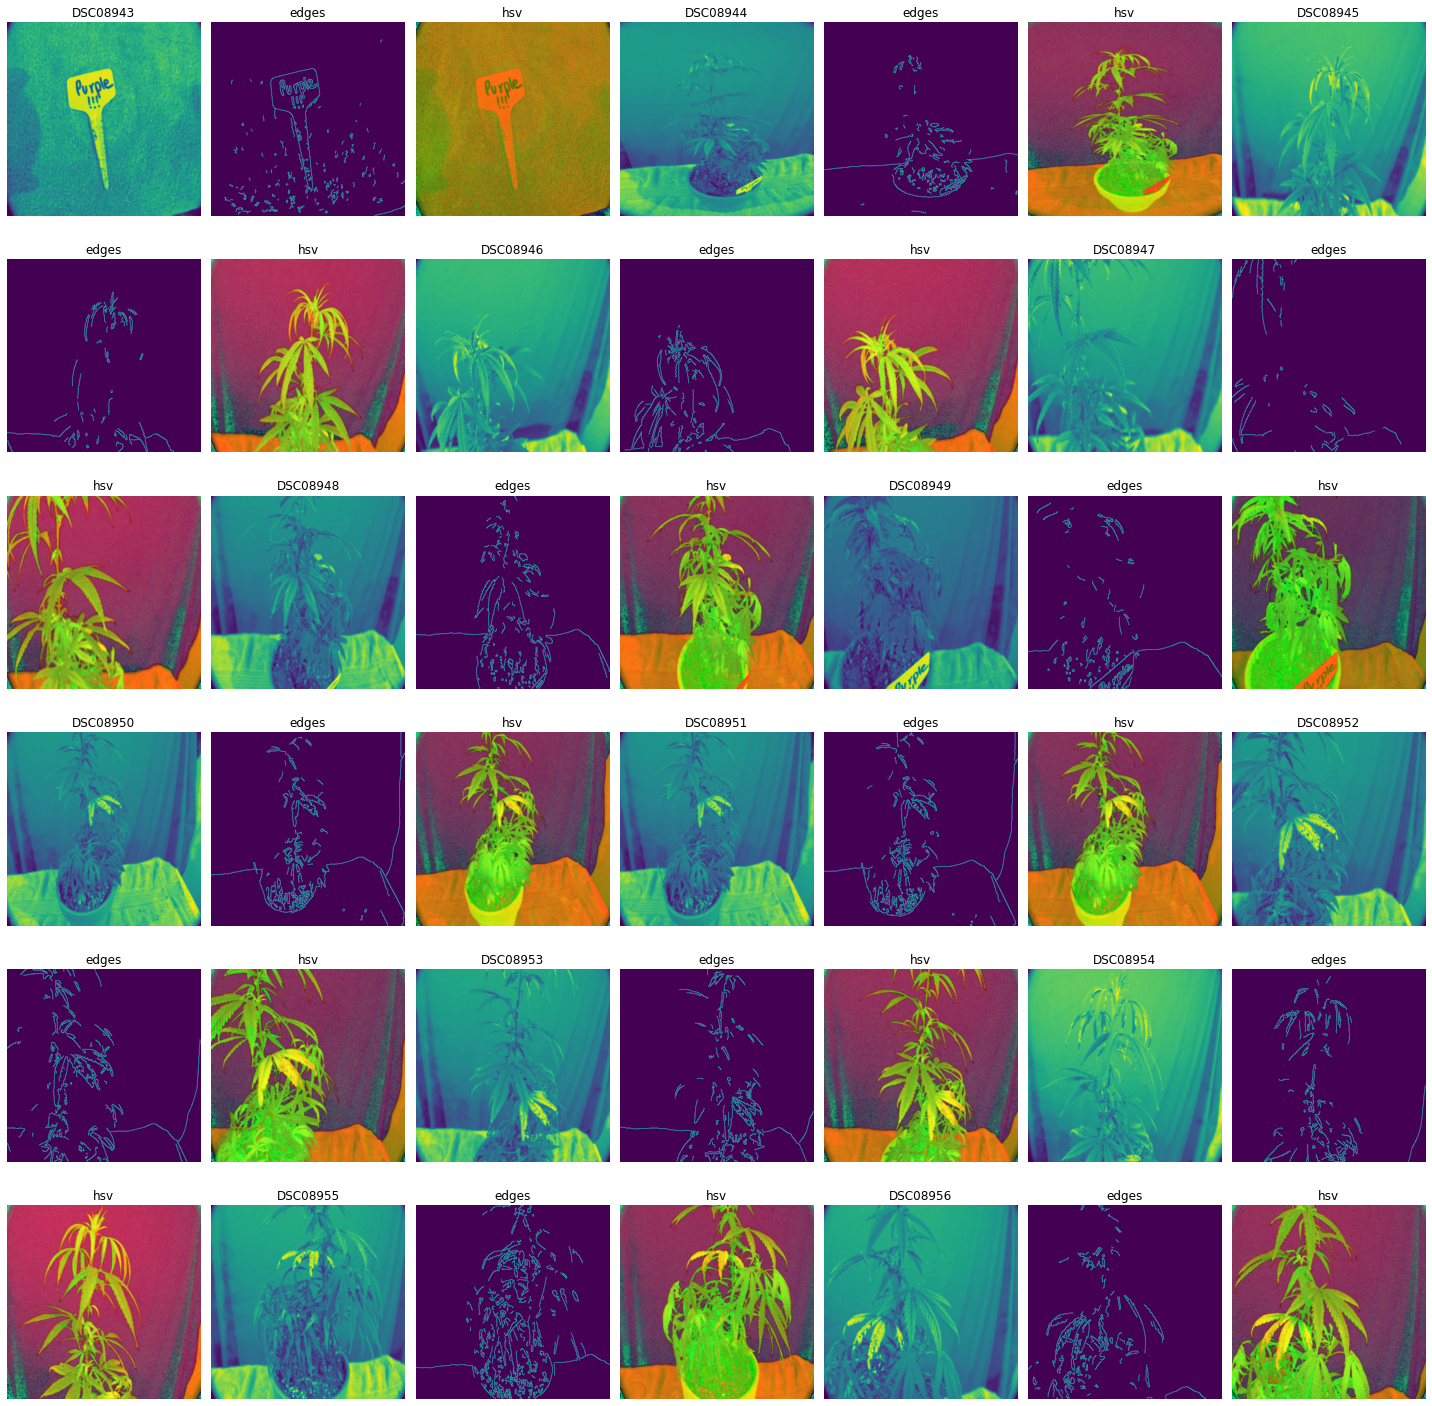

In [39]:

from PIL import Image
import matplotlib.pyplot as plt
import math

def show_generated_images(folder_path):
    image_files = glob.glob(os.path.join(folder_path, "*.png"))
    
    num_images = len(image_files)
    
    if num_images == 0:
        print("No images found in the folder.")
        return

    num_rows = int(math.sqrt(num_images))
    num_cols = math.ceil(num_images / num_rows)
    
    plt.figure(figsize=(20, 20))
    
    for i, image_file in enumerate(image_files, start=1):
        img = Image.open(image_file)
        
        title = os.path.splitext(os.path.basename(image_file))[0].split("_")[-1]
        title = title.split('.')[0] # get the part between _ and .png
        plt.subplot(num_rows, num_cols, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(folder_path, title +'.png'))
    plt.show()

    
folder_path_1 = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2\\'

show_generated_images(folder_path_1)

This cell here below is a troubleshooting cell, essentially shows us our current directory as I was not sure. 

In [17]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Construct the full file path
file_path = os.path.join(current_dir, "array_preprocess.npy")

# Load the array from the .npy file
array = np.load(file_path)
print(f"Features array saved to: {os.path.abspath('array_preprocess.npy')}")


# Define the source and destination paths
dst_path = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2\array_preprocess.npy'

# Copy the file
os.makedirs(os.path.dirname(dst_path), exist_ok=True) # create the destination folder if it does not exist
os.replace(file_path, dst_path) # replace the file in the destination folder with the new file


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\rober\\Downloads\\array_preprocess.npy'

Array looks beautiful doesnt it? Remember, CANNY is up here, which means we can always tweak our canny settings, as well as everything else, this is like the fine tuning engine right here. 

In [7]:
# ALTERNATIVE TO THE PREPROCESSING CODE<

# from skimage import feature
# from skimage import color

# def extract_features(preprocessed_folder):
#     preprocessed_files = glob.glob(os.path.join(preprocessed_folder, "*.png"))
#     features_array = []

#     for preprocessed_file in preprocessed_files:
#         img = cv2.imread(preprocessed_file)

#         # Convert the image to grayscale
#         gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#         # Extract the histogram of oriented gradients (HOG) feature
#         hog_feature = feature.hog(gray_img)

#         # Gaussian blur
#         blur = cv2.GaussianBlur(gray_img, (5, 5), 0)

#         edges = cv2.Canny(gray_img, 100, 200)

#         # Compute the color histogram
#         color_hist = color.rgb2gray(img).flatten()

#         # Combine the features
#         combined_features = np.concatenate((hog_feature, color_hist))
        
#         features_array.append(combined_features)
        
#     return features_array

# features_array = extract_features(preprocessed_folder)

# print(features_array[1])    

Now we start the Clustering, we are choosing 5 for now. These are the amount of colors we want to extract out. 

In [8]:


# # Define the source and destination paths
# folder_path_1 = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2\\'
# output_folder = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2\kmeans\\'

# # Get a list of all the preprocessed image files in the input folder
# file_list = [f for f in os.listdir(folder_path_1) if f.endswith('.png')]

# # Create an empty array to store the feature vectors for each image
# X = np.empty((len(file_list), 500*500*3))

# # Load each image, resize it, and store its feature vector in X
# for i, file_name in enumerate(file_list):
#     file_path = os.path.join(folder_path_1, file_name)
#     img = cv2.imread(file_path)
#     img = cv2.resize(img, (500, 500))
#     img_flat = img.flatten()
#     X[i] = img_flat

# # Apply K-means clustering with 8 clusters
# kmeans = KMeans(n_clusters=8)
# kmeans.fit(X)

# # Assign each image to its corresponding cluster
# cluster_assignments = kmeans.labels_

# # Save the cluster assignments to a file
# np.save(os.path.join(output_folder, 'cluster_assignments.npy'), cluster_assignments)

# # Save the cluster centroids as images
# for i, centroid in enumerate(kmeans.cluster_centers_):
#     centroid_img = centroid.reshape((500, 500, 3))
#     output_path = os.path.join(output_folder, f'centroid_{i}.png')
#     cv2.imwrite(output_path, centroid_img)



def cluster_features(features_array, k=5):
    kmeans = KMeans(n_clusters=k)
    cluster_assignments = kmeans.fit_predict(features_array)

    return cluster_assignments

k = 5
cluster_assignments = cluster_features(features_array, k)
np.save("cluster_assignments.npy", cluster_assignments)

# Load the array from the .npy file
array = np.load("cluster_assignments.npy")
print(f"Cluster assignments saved to: {os.path.abspath('cluster_assignments.npy')}")

# Define the source and destination paths
src_path = "cluster_assignments.npy"
dst_path = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2\cluster_assignments.npy'

# Copy the file
os.makedirs(os.path.dirname(dst_path), exist_ok=True) # create the destination folder if it does not exist
os.replace(src_path, dst_path) # replace the file in the destination folder with the new file


Same thing as above but now we are dealing with a KMEANS of the colors. In this case we have chosen 4 clusters. 

RESULT : 4 clusters makes for mostly green pictures in our kmeans output. so below is going to be 8 clusters.


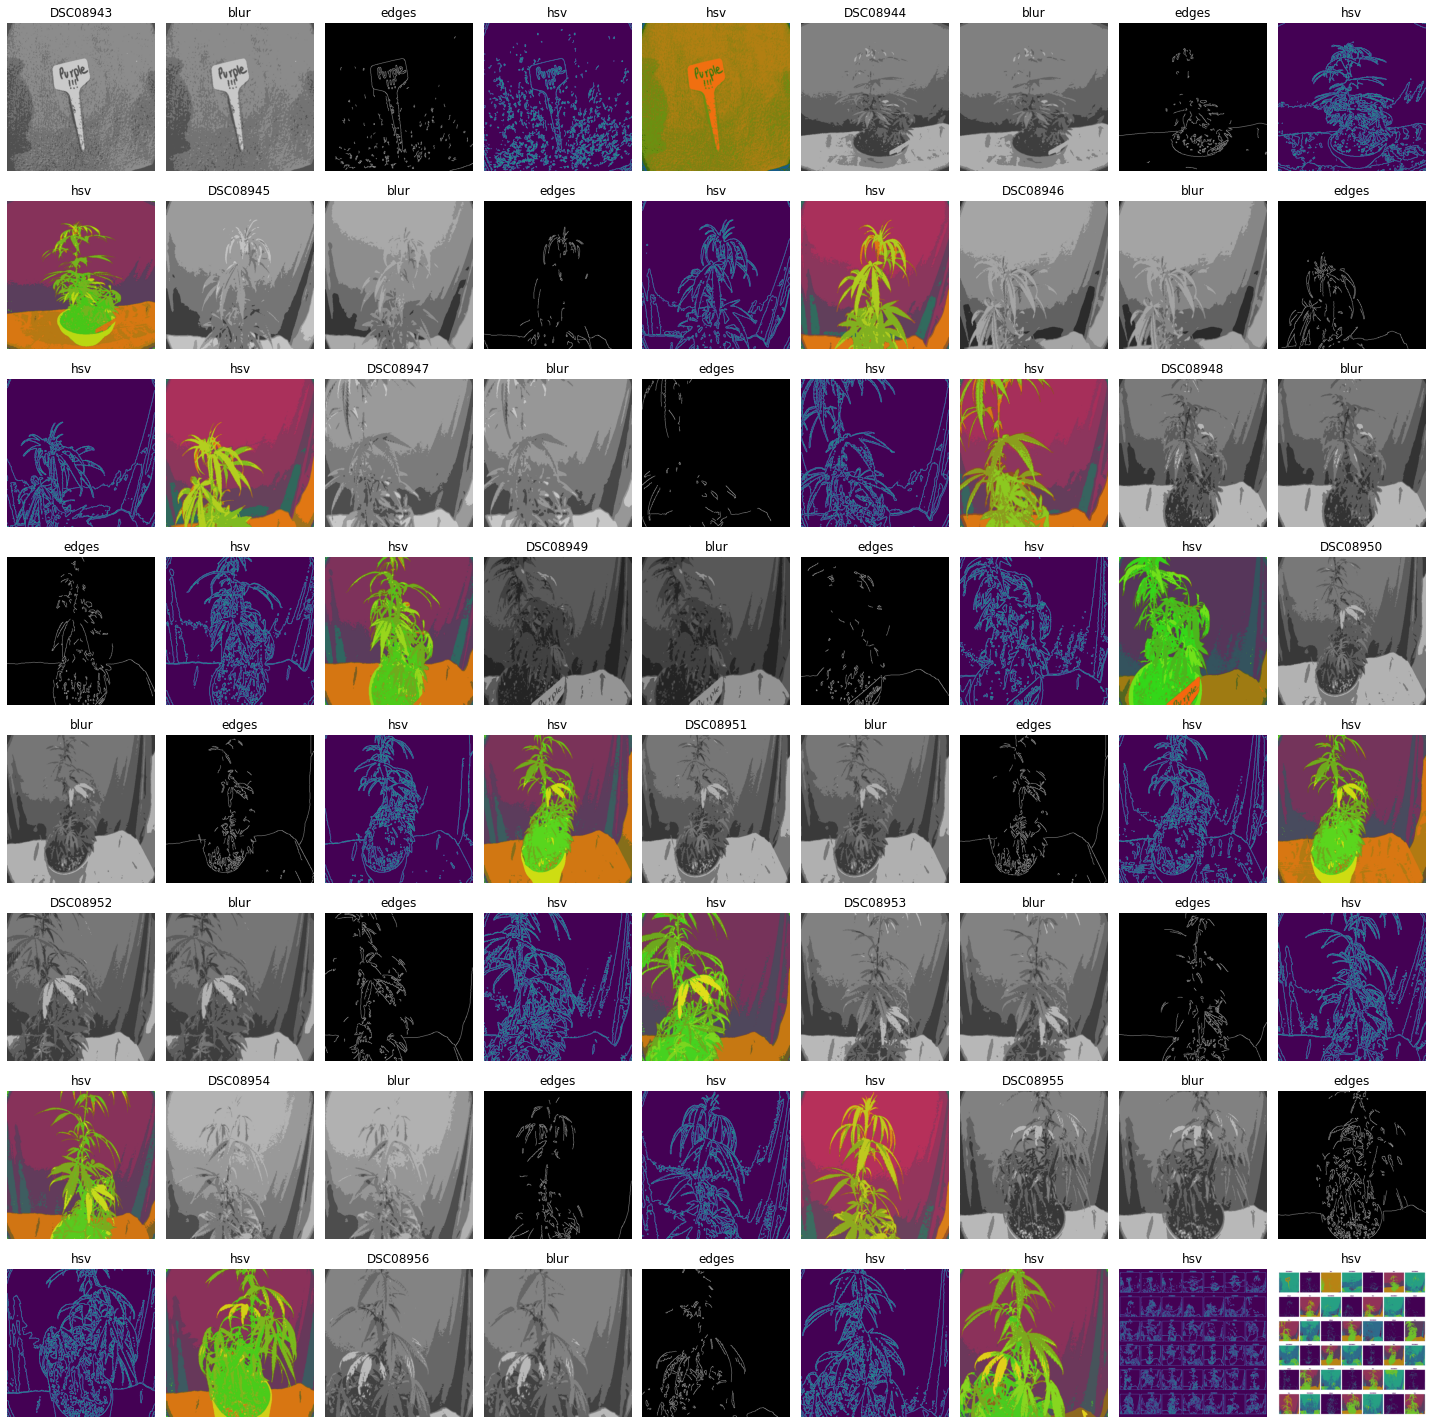

In [40]:

# Define the source and destination paths
folder_path_1 = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2\\'
output_folder = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2\kmeans_output\\'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define the number of clusters
num_clusters = 8

# Loop over each file in the source folder
for filename in os.listdir(folder_path_1):
    if filename.endswith('hsv.png'):
        # Load the preprocessed image
        image_path = os.path.join(folder_path_1, filename)
        image = cv2.imread(image_path)

        # Flatten the image into a 2D array of pixels
        pixels = np.reshape(image, (-1, 3))

        # Run KMeans clustering on the flattened image
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(pixels)

        # Reshape the cluster centers back into the original image shape
        cluster_centers = kmeans.cluster_centers_.astype('uint8')
        segmented_image = cluster_centers[kmeans.labels_]
        segmented_image = np.reshape(segmented_image, image.shape)

        # Save the segmented image to the output folder
        output_path = os.path.join(output_folder, f'{filename}-KMeans-Segmented.png')
        cv2.imwrite(output_path, segmented_image)
        
        edges = cv2.Canny(segmented_image, 100, 200)
        output_path = os.path.join(output_folder, f'{filename}-KMeans-Segmented-edges.png')
        cv2.imwrite(output_path, edges)


show_generated_images(output_folder)




In [35]:
import shutil

source_folder = 'C:\\Users\\rober\\Pictures\\mar 21\\purple !!!\\preprocessed_step2\\'
destination_folder = 'C:\\Users\\rober\\Pictures\\mar 21\\purple !!!\\preprocessed_step2\\gray\\'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Loop through all the files in the source folder
for filename in os.listdir(source_folder):
    # Check if the file ends with "_blur.png"
    if filename.endswith("_blur.png"):
        # Construct the file paths for the source and destination
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_folder, filename)

        # Move the file from the source folder to the destination folder
        shutil.move(source_path, destination_path)


This process here is not documented, but it took a while figuring out what exact values to generate in this loop. First we do not want it to be too big, nor do we want the wrong values for the edge detection. 


<ipython-input-39-1080de0b6d72>:29: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


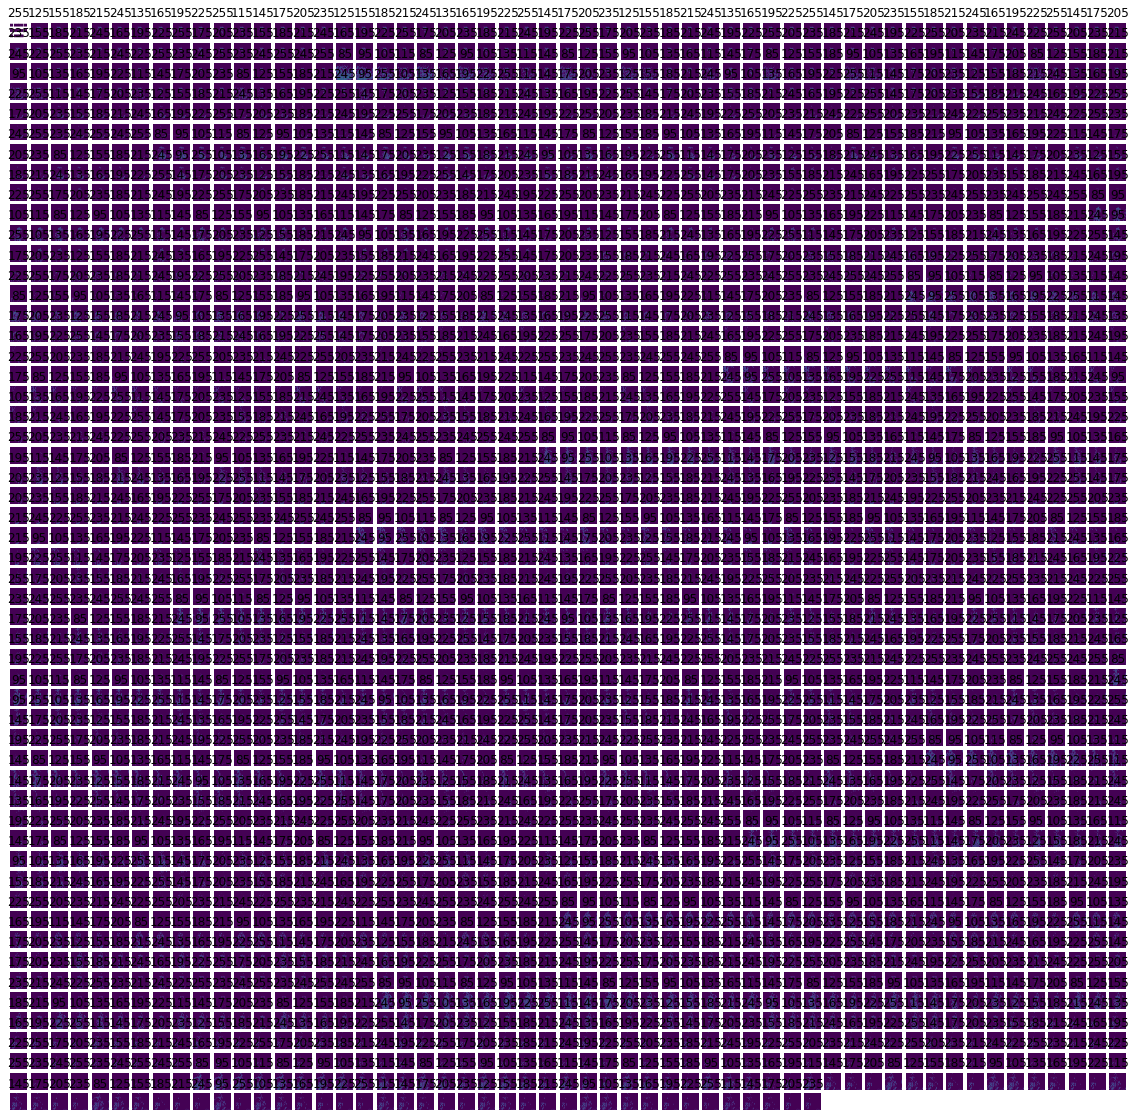

In [44]:

preprocessed_folder = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2\gray\\'
output_folder = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2\canny_output_4\\'

def canny_test(preprocessed_folder, output_folder):
    high_threshold = 255
    low_threshold = high_threshold / 3

    highThreshold_range = range(255//3, 256, 10)
    array_ab = [(low, high) for high in highThreshold_range for low in range(high//3, high, 10)]

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(preprocessed_folder):
        image_path = os.path.join(preprocessed_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        for a, b in array_ab:
            output_path = os.path.join(output_folder, f'{filename}-canny{a}_{b}.png')

            # Check if the output image already exists
            if os.path.exists(output_path):
                continue

            edges = cv2.Canny(image, a, b)
            cv2.imwrite(output_path, edges)

    show_generated_images(output_folder)

canny_test(preprocessed_folder, output_folder)


I really like what i see with settings around 48,85 and 78,205 so i am making two saved thresholds for those two. 

In [64]:


preprocessed_folder_plant = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed\plants\\'
preprocessed_folder_label = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed\label\\'

save_folder_plants = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2_plants\\'
save_folder_labels = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2_labels\\'
## ASK FOR HELP HERE. THIS DOES NOT WORK, IS IT EVEN WORTH INVESTING TIME IN?

def extract_features_plants(preprocessed_folder, save_folder):

    preprocessed_files = glob.glob(os.path.join(preprocessed_folder,"*.*"))
    features_array = None
    print(f"Number of files found: {len(preprocessed_files)}")
    for i, preprocessed_file in enumerate(preprocessed_files):
        img = cv2.imread(preprocessed_file)
        print(f"Processing file: {preprocessed_file}")
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Save the grayscale image
        gray_file = os.path.join(save_folder, os.path.basename(preprocessed_file))
        cv2.imwrite(gray_file, gray_img)
        print(f"Grayscale image saved: {gray_file}")
        # Extract the histogram of oriented gradients (HOG) feature
        hog_feature = feature.hog(gray_img)

        # Gaussian blur
        blur = cv2.GaussianBlur(gray_img, (5, 5), 0)
        # Save the blurred image
        blur_file = os.path.join(save_folder, os.path.splitext(os.path.basename(preprocessed_file))[0] + '_blur.png')
        cv2.imwrite(blur_file, blur)

        edges = cv2.Canny(gray_img, 48, 85)

        # Save the edges image
        edges_file = os.path.join(save_folder, os.path.splitext(os.path.basename(preprocessed_file))[0] + '_edges.png')
        cv2.imwrite(edges_file, edges)
        

        # Compute the color histogram
        color_hist = color.rgb2gray(img).flatten()

        # Convert the image to HSV color space to identify the location of different colors
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Save the HSV image
        hsv_file = os.path.join(save_folder, os.path.splitext(os.path.basename(preprocessed_file))[0] + '_hsv.png')
        cv2.imwrite(hsv_file, hsv)
        print(f"HSV image saved: {hsv_file}")
        # Combine the features
        combined_features = np.concatenate((hog_feature, color_hist))
        num_features = len(hog_feature) + len(color_hist)

        if features_array is None:
            features_array = np.empty((len(preprocessed_files), num_features))

        features_array[i] = combined_features

    return features_array




def extract_features_labels(preprocessed_folder, save_folder):
    preprocessed_files = glob.glob(os.path.join(preprocessed_folder, "*.png"))
    features_array = None

    for i, preprocessed_file in enumerate(preprocessed_files):
        img = cv2.imread(preprocessed_file)

        # Convert the image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Save the grayscale image
        gray_file = os.path.join(save_folder, os.path.basename(preprocessed_file))
        cv2.imwrite(gray_file, gray_img)

        # Extract the histogram of oriented gradients (HOG) feature
        hog_feature = feature.hog(gray_img)

        # Gaussian blur
        blur = cv2.GaussianBlur(gray_img, (5, 5), 0)
        # Save the blurred image
        blur_file = os.path.join(save_folder, os.path.splitext(os.path.basename(preprocessed_file))[0] + '_blur.png')
        cv2.imwrite(blur_file, blur)

        edges = cv2.Canny(gray_img, 78, 205)

        # Save the edges image
        edges_file = os.path.join(save_folder, os.path.splitext(os.path.basename(preprocessed_file))[0] + '_edges.png')
        cv2.imwrite(edges_file_, edges)
        

        # Compute the color histogram
        color_hist = color.rgb2gray(img).flatten()

        # Convert the image to HSV color space to identify the location of different colors
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Save the HSV image
        hsv_file = os.path.join(save_folder, os.path.splitext(os.path.basename(preprocessed_file))[0] + '_hsv.png')
        cv2.imwrite(hsv_file, hsv)

        # Combine the features
        combined_features = np.concatenate((hog_feature, color_hist))
        num_features = len(hog_feature) + len(color_hist)

        if features_array is None:
            features_array = np.empty((len(preprocessed_files), num_features))

        features_array[i] = combined_features

    return features_array

features_array_plants = extract_features_plants(preprocessed_folder, save_folder_plants)
features_array_labels = extract_features_labels(preprocessed_folder, save_folder_labels)

array_preprocess_plants = np.save("array_preprocess_plants.npy", features_array_plants)
array_preprocess_labels = np.save("array_preprocess_labels.npy", features_array_labels)


Number of files found: 0


In [12]:
######### This is superflous code for a kmeans clustering.

# # Define the source and destination paths
# # folder_path_1 = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2\\'

# def process_images_kmeans():
#     input_folder = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2\\'
#     output_folder = '/content/drive/MyDrive/cannabis_kmeans_1/output_images/'
#     os.makedirs(output_folder, exist_ok=True)

#     # Get a list of all the files in the input folder
#     file_list = os.listdir(input_folder)

#     for file_name in file_list:
#         # Check if the file is a PNG image
#         if file_name.endswith('.png'):
#             print(f"Processing image {file_name}")
#             file_path = os.path.join(input_folder, file_name)
#             print(f"File path: {file_path}")
#             img = io.imread(file_path)

#             if img is not None:
#                 img_flat = img.reshape(-1, 3)
#                 kmeans = KMeans(n_clusters=8)
#                 kmeans.fit(img_flat)
#                 segmented_img_flat = kmeans.cluster_centers_[kmeans.labels_].astype("uint8")
#                 segmented_img = segmented_img_flat.reshape(img.shape)
                
#                 output_path = os.path.join(output_folder, f'{file_name}-KMeans-Segmented.png')
#                 cv2.imwrite(output_path, segmented_img)
#                 print(f"Image saved at: {output_path}")
#                 print("Image processing complete")
#             else:
#                 print(f"Image could not be read for file '{file_path}'")
#         else:
#             print(f"Skipping non-PNG file '{file_name}'")

# # Call the function to process the images
# process_images_kmeans()


In [ ]:
######### This is superflous code for a kmeans clustering.



# import os
# import cv2
# import numpy as np
# from skimage import io
# from sklearn.cluster import KMeans

# preprocessed_folder = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2'
# save_folder = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2'


# def process_images_kmeans(recursive=False, regex_str=None):
#     os.makedirs(save_folder, exist_ok=True)
    
#     if recursive:
#         file_list = []
#         for root, dirs, files in os.walk(preprocessed_folder):
#             for file in files:
#                 if file.endswith('.jpg') or file.endswith('.png'):
#                     file_list.append(os.path.join(root, file))
#     else:
#         file_list = [os.path.join(preprocessed_folder, file) for file in os.listdir(preprocessed_folder) 
#                      if file.endswith('.jpg') or file.endswith('.png')]
    
#     for file_path in file_list:
#         if regex_str and regex_str not in file_path:
#             continue  # skip files not matching the regex string
        
#         print(f"Processing image {file_path}")
#         img = io.imread(file_path)

#         if img is not None:
#             img_flat = img.reshape(-1, 3)
#             kmeans = KMeans(n_clusters=4)
#             kmeans.fit(img_flat)
#             segmented_img_flat = kmeans.cluster_centers_[kmeans.labels_].astype("uint8")
#             segmented_img = segmented_img_flat.reshape(img.shape)
            
#             output_path = os.path.join(save_folder, f'cannabis-{os.path.basename(file_path)[:-4]}-KMeans-Segmented.png')
#             cv2.imwrite(output_path, segmented_img)
#             print(f"Image saved at: {output_path}")
#             print("Image processing complete")
#         else:
#             print(f"Image could not be read for file '{file_path}'")

#     return save_folder

# kmean_pics = process_images_kmeans(preprocessed_folder)
# show_generated_images(kmean_pics)

8 Clusters. 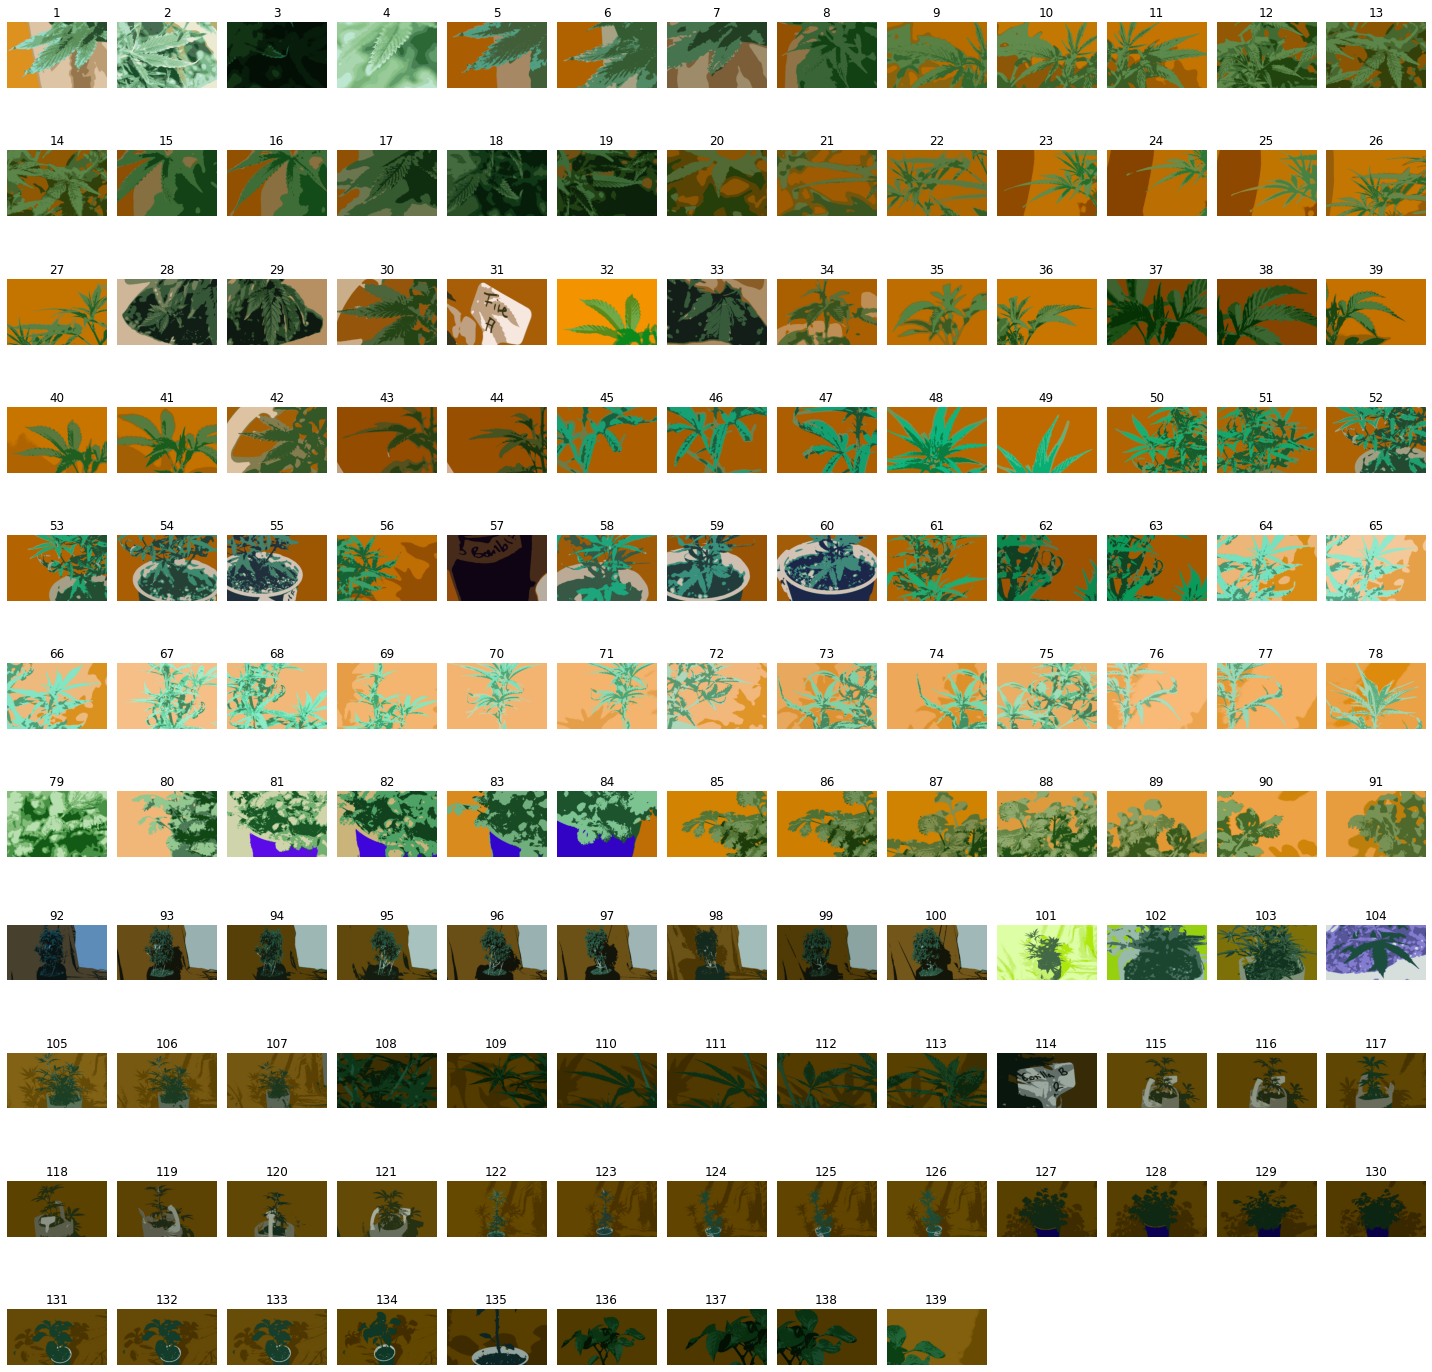

In [ ]:
import os
import cv2
import numpy as np
from skimage import io
from sklearn.cluster import KMeans

preprocessed_folder = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed'
save_folder = r'C:\Users\rober\Pictures\mar 21\purple !!!\preprocessed_step2\kmeans-hsv'

def process_images_kmeans(regex_str=None):
    os.makedirs(save_folder, exist_ok=True)
    
    for filename in os.listdir(preprocessed_folder):
        
        if regex_str and regex_str not in filename:
            continue  # skip files not matching the regex string
        
        file_path = os.path.join(preprocessed_folder, filename)
        print(f"Processing image {file_path}")
        img = io.imread(file_path)
        
        if filename.endswith('hsv.png'):

            if img is not None:
                
                img_flat = img.reshape(-1, 3)
                kmeans = KMeans(n_clusters=8)
                kmeans.fit(img_flat)
                segmented_img_flat = kmeans.cluster_centers_[kmeans.labels_].astype("uint8")
                segmented_img = segmented_img_flat.reshape(img.shape)
                
                output_path = os.path.join(save_folder, f'cannabis-{filename[:-4]}-KMeans-Segmented.png')
                cv2.imwrite(output_path, segmented_img)
                print(f"Image saved at: {output_path}")
                print("Image processing complete")
            else:
                print(f"Image could not be read for file '{file_path}'")

process_images_kmeans(preprocessed_folder)
show_generated_images(save_folder)

We are calling arrays for the colors. The colors are not perfect. My current idea is that i should take the color picker tool and pick out color ranges for colors. I have somewhat tried to do this with the kmeans, however they don't entirely play together. 

The next step is that we actually do some AI! Canny edge detection set at **50 and 150 (NEEDS TWEAKING**). We are making contours for each color section. 

=The next step needs to include saving a MASKED photo, of the contour. not just the contour outline .

In [ ]:

from skimage import io

# Define the color ranges for each color
green_lower = np.array([20, 20, 10])
green_upper = np.array([80, 220, 80])
yellow_lower = np.array([190, 190, 80])
yellow_upper = np.array([255, 255, 130])
brown_lower = np.array([70, 40, 30])
brown_upper = np.array([180, 140, 105])
purple_lower = np.array([60, 40, 55])
purple_upper = np.array([200, 110, 200])
color_ranges = [(green_lower, green_upper), (yellow_lower, yellow_upper), (brown_lower, brown_upper), (purple_lower, purple_upper)]
colors = ['Green', 'Yellow', 'Brown', 'Purple']

def process_images():
    output_folder = '/output_images/'
    
    output_path = os.path.join(output_folder, preprocessed_folder)
    
    
    os.makedirs(output_folder, exist_ok=True)

    for i in range(10, 50):
        print(f"Processing image {i}")
        file_path = preprocessed_folder
        print(f"File path: {file_path}")
        img = io.imread(file_path)

        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray, 50, 150)
            contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]


            for j, color_range in enumerate(color_ranges):
                lower_range = np.array(color_range[0])
                upper_range = np.array(color_range[1])
                mask = cv2.inRange(hsv, lower_range, upper_range)
                segmented = cv2.bitwise_and(img, img, mask=mask)
                cv2.imwrite(f'{output_folder}cannabis-{i}-{colors[j]}-Segmented.png', segmented)

            output_path = f'{output_folder}cannabis-{i}-Contour.png'
            cv2.imwrite(output_path, img)
            print(f"Image saved at: {output_path}")
            print("Image processing complete")
        else:
            print(f"Image could not be read for file '{file_path}'")

# Call the function to process the images
process_images()


Using KMEANS to see the percentages of each color, this can be a basic health metric. For example, any yellow in the plant should be immediate concern! Even slight yellowing means we are already losing vitality. Therefore, the system has *to be tuned * but we can consider the fact that there are certain colors that are beneficial, and others that are not. This may also be strain specific. 

In [ ]:



# Define the color ranges for each color
green_lower = np.array([20, 20, 10])
green_upper = np.array([80, 220, 80])
yellow_lower = np.array([190, 190, 80])
yellow_upper = np.array([255, 255, 130])
brown_lower = np.array([70, 40, 30])
brown_upper = np.array([180, 140, 105])
purple_lower = np.array([60, 40, 55])
purple_upper = np.array([200, 110, 200])
color_ranges = [(green_lower, green_upper), (yellow_lower, yellow_upper), (brown_lower, brown_upper), (purple_lower, purple_upper)]
colors = ['Green', 'Yellow', 'Brown', 'Purple']


# Add more color ranges and names
color_ranges = [
    (green_lower, green_upper, 'Green'),
    (yellow_lower, yellow_upper, 'Yellow'),
    (brown_lower, brown_upper, 'Brown'),
    (purple_lower, purple_upper, 'Purple')
    # Add more colors here
  
]


def get_color_percentages(image, num_clusters):
    # Reshape the image to be a list of pixels
    pixels = image.reshape(-1, 3)

    # Apply K-means clustering to the pixels
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(pixels)

    # Count the number of pixels in each cluster
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    pixel_counts = dict(zip(unique, counts))

    # Calculate the percentage of pixels in each cluster
    percentages = [count / sum(pixel_counts.values()) * 100 for count in pixel_counts.values()]

    return kmeans.cluster_centers_.astype(int), percentages



# Modify the `analyze_plant_health` function to return a dictionary with color percentages
def analyze_plant_health(image_path, num_clusters=8):
    segmented_img = cv2.imread(image_path)
    color_percentages = {}

    if segmented_img is not None:
        unique_colors, percentages = get_color_percentages(segmented_img, num_clusters)  # Change function name

        for color, percentage in zip(unique_colors, percentages):
            for lower_range, upper_range, color_name in color_ranges:
                if (color >= lower_range).all() and (color <= upper_range).all():
                    color_category = color_name
                    break
            else:
                color_category = 'Other'

            color_percentages[color_category] = percentage

    else:
        print(f"Image could not be read for file '{image_path}'")

    return color_percentages

# Example usage
folder_path = '/content/drive/MyDrive/cannabis_kmeans_1/output_images/'
image_color_percentages = process_all_images(folder_path, num_clusters=4)

# Convert the list of dictionaries to a NumPy array
color_names = [color_info[2] for color_info in color_ranges]
color_names.append('Other')

array_data = np.zeros((len(image_color_percentages), len(color_names)))

for i, color_percentages in enumerate(image_color_percentages):
    for j, color_name in enumerate(color_names):
        array_data[i, j] = color_percentages.get(color_name, 0)

print("Color percentages array:")
print(array_data)


More of the above, here we are setting thresholds for the specific colors and giving the user a response in case we think there is actually an issue. 

Color percentages array:
<pre>[[16.0990991   0.          0.          0.         23.47567568]
 [ 5.91111111  0.          0.          0.         34.35915916]
 [19.67507508  0.          0.          0.         43.13873874]
 [ 0.94774775  0.          0.          0.         27.18978979]
 [29.81981982  0.          0.          0.         18.38258258]
 [34.12192192  0.         20.53453453  0.          9.57237237]
 [10.53633634  0.          0.          0.         29.86666667]
 [33.03843844  0.          0.          0.         11.92372372]
 [25.22462462  0.         24.49009009  0.         10.14234234]
 [24.46486486  0.         35.45345345  0.         14.42282282]
 [21.77177177  0.         23.9957958   0.         40.46306306]
 [35.25465465  0.          0.          0.          7.98498498]
 [25.34114114  0.         34.15255255  0.         20.16576577]
 [16.65405405  0.          0.          0.         19.3975976 ]
 [36.68408408  0.          0.         21.26426426 10.3981982 ]
 [29.95675676  0.          0.         20.91351351 25.53513514]
 [42.37057057  0.          0.          0.         18.71711712]
 [16.85165165  0.          0.          0.         43.42882883]
 [28.84564565  0.          0.          0.         11.18018018]
 [ 0.          0.          0.          0.         30.10690691]
 [18.14594595  0.          0.          0.         12.83963964]
 [ 8.87747748  0.          0.          0.         16.33813814]
 [ 8.66786787  0.         12.12552553  0.         46.37777778]
 [10.95375375  0.          0.          0.          3.66846847]
 [11.74714715  0.          0.          0.         38.93993994]
 [ 6.53873874  0.          0.          0.          8.57717718]
 [12.53333333  0.         13.72312312  0.          5.92012012]
 [36.92912913  0.          0.          0.         17.32552553]
 [19.79099099  0.          0.          0.         23.98258258]
 [39.64864865  0.          0.          0.         11.5015015 ]
 [ 4.25105105  0.          0.          0.         23.95015015]
 [10.04144144  0.          0.          0.          4.93813814]
 [33.16996997  0.          0.          0.         12.27687688]
 [27.45885886  0.          0.          0.         50.72852853]
 [ 9.98558559  0.         14.11351351  0.          9.91711712]
 [10.56876877  0.         12.82162162  0.          2.81741742]
 [23.60660661  0.          0.          0.          8.27567568]
 [23.7975976   0.          0.          0.          6.02942943]
 [ 8.22342342  0.          0.          0.          7.67867868]
 [12.30870871  0.          0.          0.         12.61201201]
 [13.17117117  0.          0.          0.         27.4972973 ]
 [33.21861862  0.          0.          0.         19.32192192]
 [21.92252252  0.          0.          0.          0.60840841]
 [19.16216216  0.          0.          0.          0.56396396]
 [10.65105105  0.          0.          0.         12.8012012 ]
 [ 3.72372372  0.         16.94354354  0.         22.35135135]
 [ 9.53753754  0.          0.          0.         58.26006006]
 [ 0.          0.          0.          0.         13.66786787]
 [ 0.          0.          0.          0.          5.38198198]
 [25.5957958   0.          0.          0.          6.07687688]
 [41.64564565  0.          0.          0.         10.25345345]
 [23.5027027   0.          0.          0.         14.75195195]
 [30.34114114  0.          0.          0.          9.52312312]
 [29.77657658  0.         27.6996997   0.         13.41921922]
 [19.91951952  0.         26.47747748  0.         36.44744745]
 [28.16036036  0.          0.          0.          5.16816817]
 [36.50690691  0.          0.          0.          2.71171171]
 [24.78798799  0.          0.          0.         29.38498498]
 [32.67207207  0.          0.          0.         21.16216216]
 [26.34894895  0.         37.90750751  0.         14.81741742]
 [24.43183183  0.          0.          0.          6.41501502]
 [18.37357357  0.         10.15135135  0.         22.3039039 ]
 [17.41381381  0.         10.003003    0.         50.90810811]
 [ 0.          0.          5.42522523  0.         31.6978979 ]
 [ 0.         28.66126126  4.81501502  0.         33.38318318]
 [ 0.         22.15915916  0.          0.         38.72552553]
 [ 0.          0.          8.06906907  0.         18.21981982]
 [ 0.          0.         11.72072072  0.         13.95615616]
 [ 0.         11.35855856  0.          0.          6.03723724]
 [ 0.          0.          0.          0.          9.95495495]
 [ 0.          8.93333333  0.          0.         10.50930931]
 [ 0.          0.          0.          0.         42.71291291]
 [ 0.          0.          0.          0.         42.43423423]
 [ 0.          0.          0.          0.         24.3957958 ]
 [ 0.          0.         12.36276276  0.         29.57057057]
 [ 0.          0.          0.          0.         22.19039039]
 [ 0.          0.          0.          0.         52.76276276]
 [ 0.          0.          0.          0.         13.0966967 ]
 [24.48468468  0.          0.          0.         13.81381381]
 [21.9963964   0.          0.          0.         22.95255255]
 [25.91891892  0.          0.          0.         11.13393393]
 [31.1987988   0.          0.          0.         18.88108108]
 [30.03723724  0.          0.          0.          6.69069069]
 [27.66666667  0.          0.          0.         11.51651652]
 [ 0.          0.          0.          0.          7.63123123]
 [ 0.          0.          0.          0.         18.72492492]
 [21.28048048  0.          0.          0.          4.31891892]
 [18.72192192  0.         27.46426426  0.         28.56396396]
 [ 0.          0.          0.          0.          6.95015015]
 [13.83963964  0.          0.          0.          9.90990991]
 [ 0.          0.          0.          0.         29.14114114]
 [52.78647687  0.          0.          0.          3.47900356]
 [11.30533808  0.          0.          0.         14.5202847 ]
 [11.21209964  0.          0.          0.         10.77935943]
 [16.17651246  0.          6.17010676  0.         55.63914591]
 [10.7088968   0.          0.          0.         15.37793594]
 [ 8.8975089   0.          0.          0.         14.72170819]
 [ 9.16939502  0.          0.          0.         25.14163701]
 [11.83914591  0.          0.          0.         12.70462633]
 [11.9886121   0.          0.          0.         16.95587189]
 [12.81921708  0.          0.          0.          5.49537367]
 [59.59857651  0.          0.          0.         14.83487544]
 [21.45124555  0.          0.          0.          3.6341637 ]
 [22.96298932  0.         38.97864769  0.         21.89395018]
 [11.98007117  0.          0.          0.         18.19715302]
 [11.95160142  0.          7.27615658  0.         54.54092527]
 [ 7.70676157  0.          8.97580071  0.         47.13736655]
 [15.35231317  0.          0.          0.         28.28896797]
 [ 7.62562278  0.          0.          0.         27.12740214]
 [ 2.82135231  0.          0.          0.         19.60782918]
 [ 3.87829181  0.          0.          0.         61.45338078]
 [ 9.53309609  0.          0.          0.         15.99857651]
 [11.22633452  0.          0.          0.         20.39928826]
 [ 0.          0.         18.08042705  0.         34.20213523]
 [ 9.06263345  0.          0.          8.78007117  3.30604982]
 [ 0.          0.          9.20569395  0.          2.60925267]
 [ 9.7024911   0.          0.          0.         61.0341637 ]
 [ 0.          0.         10.88683274  0.         10.95017794]
 [ 6.35587189  0.         10.90533808  0.          2.89466192]
 [ 6.82348754  0.          6.67544484  0.          2.27188612]
 [ 9.6341637   0.          0.          0.         13.38434164]
 [ 3.49252669  0.          1.47330961  0.         53.78932384]
 [ 3.60498221  0.          1.67117438  0.         57.7772242 ]
 [ 2.78362989  0.          0.          0.         25.99786477]
 [ 6.64982206  0.          0.          0.          0.62562278]
 [ 7.57508897  0.          0.          0.          0.5202847 ]
 [21.52811388  0.          0.          0.          2.85124555]
 [21.58647687  0.          0.          0.         27.94021352]
 [ 0.          0.          0.          0.          3.08398577]
 [ 0.          0.          0.          0.          3.16085409]
 [16.713879    0.          0.          0.          0.58362989]
 [16.99786477  0.          0.          0.          8.81850534]
 [17.03843416  0.          0.          0.         10.89323843]
 [16.80071174  0.          0.          0.          9.25053381]
 [13.28540925  0.          0.          0.         25.97153025]
 [ 5.31174377  0.          0.          0.         16.02775801]
 [ 8.06548043  0.          0.          0.          9.23772242]
 [ 7.32384342  0.          0.          0.          7.50320285]]</pre>

In [ ]:
# Define threshold values for color ranges (in percentages)
thresholds = {
    'yellow': 10,
    'brown': 5,
    'purple': 5
}

# Define a function to check the health of the plant
def is_plant_healthy(color_percentages, thresholds):
    problems = []

    if color_percentages[1] > thresholds['yellow']:
        problems.append('Yellowing leaves (possible nutrient deficiency)')

    if color_percentages[2] > thresholds['brown']:
        problems.append('Browning leaves (possible nutrient burn or over-watering)')

    if color_percentages[3] > thresholds['purple']:
        problems.append('Purpling leaves (possible phosphorus deficiency or cold stress)')

    return problems

# Iterate through the images and check if the plant is healthy or not
for idx, color_percentages in enumerate(array_data):
    problems = is_plant_healthy(color_percentages, thresholds)
    if problems:
        print(f"Image index {idx} has the following problems:")
        for problem in problems:
            print(f"  - {problem}")
    else:
        print(f"Image index {idx} appears to be healthy.")


Image index 0 appears to be healthy.
Image index 1 appears to be healthy.
Image index 2 appears to be healthy.
Image index 3 appears to be healthy.
Image index 4 appears to be healthy.
Image index 5 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 6 appears to be healthy.
Image index 7 appears to be healthy.
Image index 8 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 9 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 10 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 11 appears to be healthy.
Image index 12 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 13 appears to be healthy.
Image index 14 has the following problems:
  - Purpling leaves (possible phosphorus deficiency or cold stress)
Image index 15 has the following problems:
  - Purpling leaves (possible phosphorus deficiency or cold stress)
Image index 16 appears to be healthy.
Image index 17 appears to be healthy.
Image index 18 appears to be healthy.
Image index 19 appears to be healthy.
Image index 20 appears to be healthy.
Image index 21 appears to be healthy.
Image index 22 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 23 appears to be healthy.
Image index 24 appears to be healthy.
Image index 25 appears to be healthy.
Image index 26 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 27 appears to be healthy.
Image index 28 appears to be healthy.
Image index 29 appears to be healthy.
Image index 30 appears to be healthy.
Image index 31 appears to be healthy.
Image index 32 appears to be healthy.
Image index 33 appears to be healthy.
Image index 34 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 35 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 36 appears to be healthy.
Image index 37 appears to be healthy.
Image index 38 appears to be healthy.
Image index 39 appears to be healthy.
Image index 40 appears to be healthy.
Image index 41 appears to be healthy.
Image index 42 appears to be healthy.
Image index 43 appears to be healthy.
Image index 44 appears to be healthy.
Image index 45 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 46 appears to be healthy.
Image index 47 appears to be healthy.
Image index 48 appears to be healthy.
Image index 49 appears to be healthy.
Image index 50 appears to be healthy.
Image index 51 appears to be healthy.
Image index 52 appears to be healthy.
Image index 53 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 54 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 55 appears to be healthy.
Image index 56 appears to be healthy.
Image index 57 appears to be healthy.
Image index 58 appears to be healthy.
Image index 59 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 60 appears to be healthy.
Image index 61 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 62 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 63 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 64 has the following problems:
  - Yellowing leaves (possible nutrient deficiency)
Image index 65 has the following problems:
  - Yellowing leaves (possible nutrient deficiency)
Image index 66 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 67 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 68 has the following problems:
  - Yellowing leaves (possible nutrient deficiency)
Image index 69 appears to be healthy.
Image index 70 appears to be healthy.
Image index 71 appears to be healthy.
Image index 72 appears to be healthy.
Image index 73 appears to be healthy.
Image index 74 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 75 appears to be healthy.
Image index 76 appears to be healthy.
Image index 77 appears to be healthy.
Image index 78 appears to be healthy.
Image index 79 appears to be healthy.
Image index 80 appears to be healthy.
Image index 81 appears to be healthy.
Image index 82 appears to be healthy.
Image index 83 appears to be healthy.
Image index 84 appears to be healthy.
Image index 85 appears to be healthy.
Image index 86 appears to be healthy.
Image index 87 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 88 appears to be healthy.
Image index 89 appears to be healthy.
Image index 90 appears to be healthy.
Image index 91 appears to be healthy.
Image index 92 appears to be healthy.
Image index 93 appears to be healthy.
Image index 94 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 95 appears to be healthy.
Image index 96 appears to be healthy.
Image index 97 appears to be healthy.
Image index 98 appears to be healthy.
Image index 99 appears to be healthy.
Image index 100 appears to be healthy.
Image index 101 appears to be healthy.
Image index 102 appears to be healthy.
Image index 103 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 104 appears to be healthy.
Image index 105 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 106 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 107 appears to be healthy.
Image index 108 appears to be healthy.
Image index 109 appears to be healthy.
Image index 110 appears to be healthy.
Image index 111 appears to be healthy.
Image index 112 appears to be healthy.
Image index 113 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 114 has the following problems:
  - Purpling leaves (possible phosphorus deficiency or cold stress)
Image index 115 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 116 appears to be healthy.
Image index 117 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 118 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 119 has the following problems:
  - Browning leaves (possible nutrient burn or over-watering)
Image index 120 appears to be healthy.
Image index 121 appears to be healthy.
Image index 122 appears to be healthy.
Image index 123 appears to be healthy.
Image index 124 appears to be healthy.
Image index 125 appears to be healthy.
Image index 126 appears to be healthy.
Image index 127 appears to be healthy.
Image index 128 appears to be healthy.
Image index 129 appears to be healthy.
Image index 130 appears to be healthy.
Image index 131 appears to be healthy.
Image index 132 appears to be healthy.
Image index 133 appears to be healthy.
Image index 134 appears to be healthy.
Image index 135 appears to be healthy.
Image index 136 appears to be healthy.
Image index 137 appears to be healthy.



The above output gave us an index of unhealthy plants, specifically "5, 8, 9, 10, 12, 14, 15, 22, 26, 34, 35, 45, 53, 54, 59, 61, 62,
    63, 64, 65, 66, 67, 68, 74, 87, 94, 103, 105, 106, 113, 114, 115,
    117, 118, 119" so we wanted to copy those out specifically, hence the hard coding, it is however something to be worked on in the next steps, that this happens automatically. 

In [ ]:


import os
from PIL import Image
import matplotlib.pyplot as plt

folder_path = '/content/drive/MyDrive/cannabis/'


# ideally i need to add the unhealthy ones in here automaticall
unhealthy_indices = [
    5, 8, 9, 10, 12, 14, 15, 22, 26, 34, 35, 45, 53, 54, 59, 61, 62,
    63, 64, 65, 66, 67, 68, 74, 87, 94, 103, 105, 106, 113, 114, 115,
    117, 118, 119
]

def show_unhealthy_images(folder_path, unhealthy_indices):
    plt.figure(figsize=(20, 20))
    for i, index in enumerate(unhealthy_indices, start=1):
        img_path = os.path.join(folder_path, f'cannabis-{index + 10}.png')
        img = Image.open(img_path)
        plt.subplot(6, 6, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Image index {index}')

    plt.tight_layout()
    plt.show()

show_unhealthy_images(folder_path, unhealthy_indices)



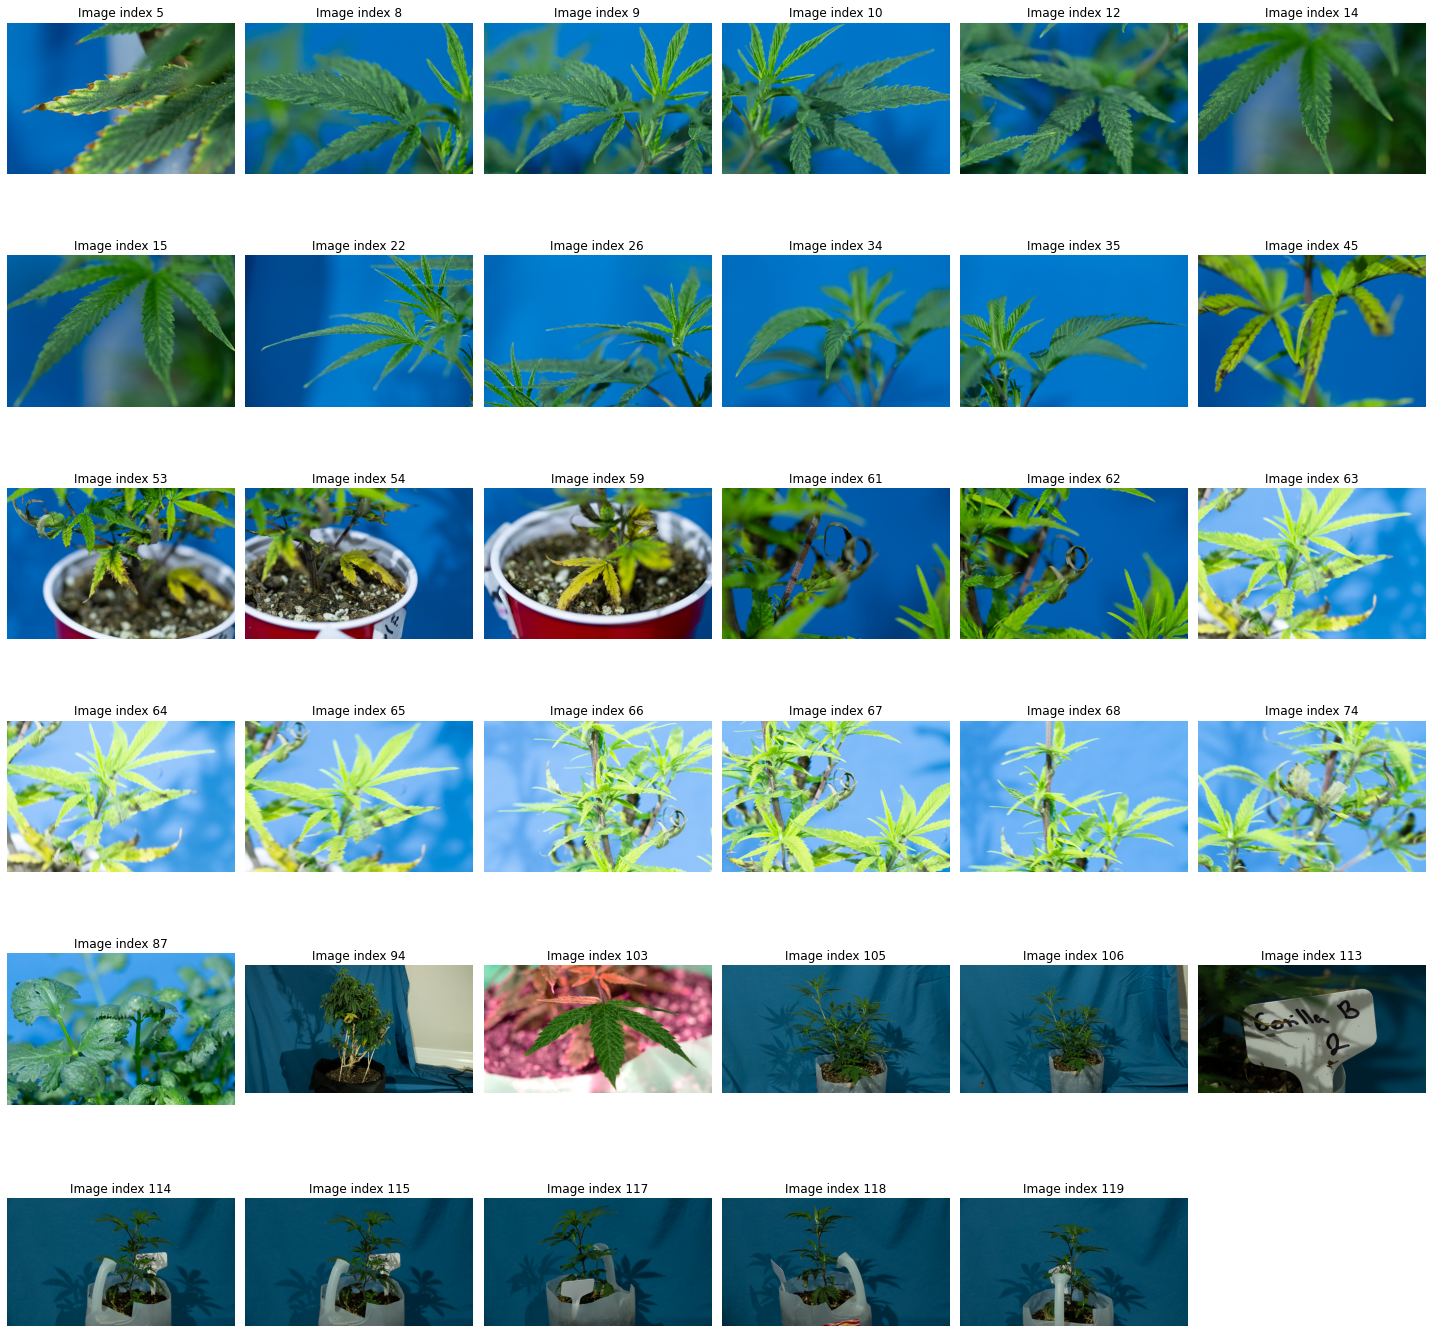

Okay for a preliminary test. Not ideal, as for example the 114-119 is not obviously showing some issues. It also seems that exposure of the image can be an issue. 